# V928 Tau - Ground Stellar Variations

This notebook is used to check whether the stellar variations calculated from the K2 light curve can noticeably be traced in the ground-based photometry collected for V928 Tau. It is expected that this will not be as obvious due to higher uncertainties and the probability that the stellar variation changes with time. We expect the rotation periods to stay the same, but there is likely to be starspot/phage modulation or migration that will distort the stellar variation model over time. Nevertheless we explore this here.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from Code import ground_variation as gv
from Code import stellar_variation as sv

%matplotlib inline

## Load the Data

Load all the photometry and plot it.

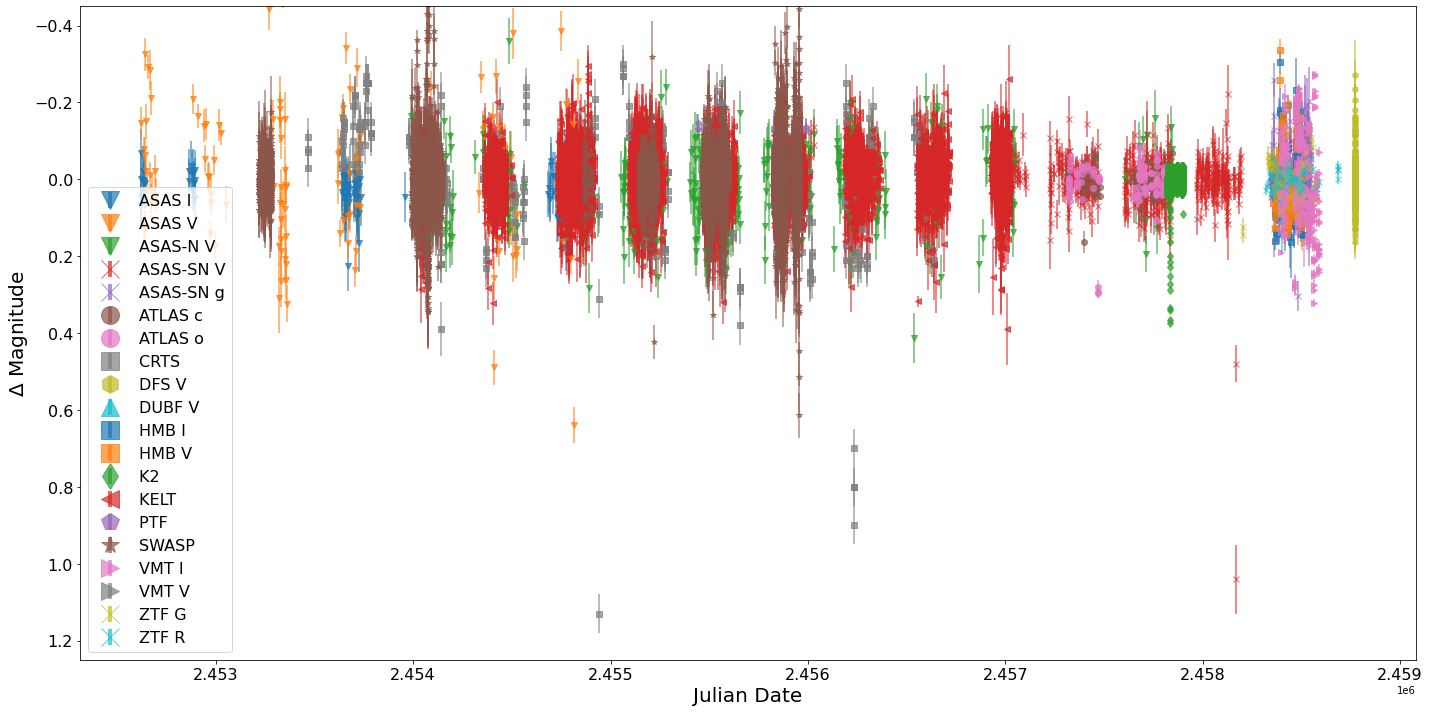

In [2]:
times, mags, errors, telescopes = gv.load_survey_data('data/photometry/all_data.txt')

gv.plot_all(times, mags, errors, telescopes, savename='plots/paper/all_phot.png')

## Load the Stellar Variation Model

Load the stellar variation model and check it against the <strong>K2</strong> light curve.

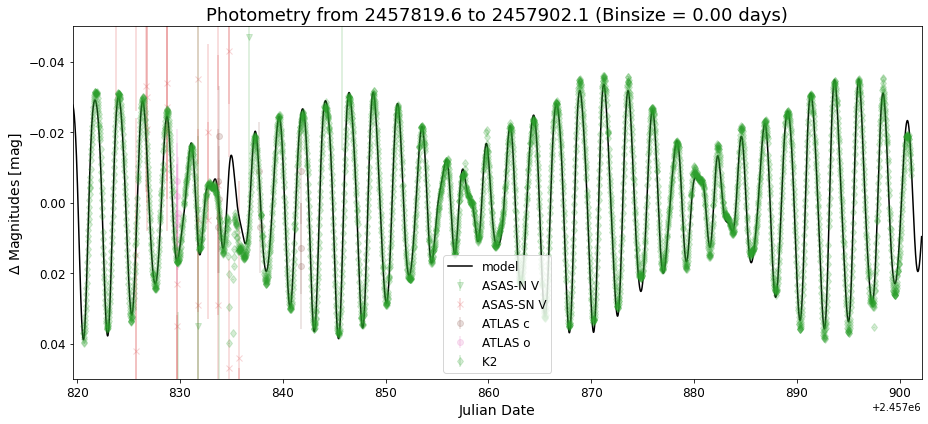

In [3]:
# extract parameters needed for the ground_stellar_variation_model
pb = np.load('models/best_fits/stellar_variation.npy')

stellar_variation = lambda P, time: sv.line(time, *P[0:2], k2_tmin) + sv.sines(time, P[2:6], P[6:10], P[10:14], k2_tmin)
ground_stellar_variation = lambda P, time: -2.5 * np.log10(stellar_variation(P, time))
k2_ind = 12
k2_tmin = times[k2_ind][0]
k2_tmax = times[k2_ind][-1]
# plot params
xlims = (k2_tmin-1, k2_tmax+1)
svm_check_args = (times, mags, errors, telescopes, ground_stellar_variation, pb)

# plot
gv.plot_part(*svm_check_args, xlim=xlims, binsize=1e-8, binned=False, ylim=(-0.05, 0.05))

## Bin and Plot the Data

Here we do several runs through the data. We bin it, and then plot in windows where we can see how well the data lines up. This section produces a lot of plots per run and thus takes quite a while and produces quite a lot of data.

In [5]:
binsizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
sigma_clips = np.array([1, 2, 3, 4, 5])
chi2_all = []
for binsize in binsizes:
    chi2_bins = []
    gv.plot_windows(*svm_check_args, ylim=(-0.1,0.1), window_size=30, binsize=binsize, unbinned_error=False)
    for sigma_clip in sigma_clips:
        chi2_bin = gv.chi2_all(*svm_check_args, binsize=binsize, sigma_clip=sigma_clip)
        chi2_bins.append(chi2_bin)
    chi2_all.append(np.array(chi2_bins))

# make one array
chi2_all = np.array(chi2_all)

100%|██████████| 234/234 [00:19<00:00, 12.10it/s]


In [35]:
def print_chi2_table(chi2s, binsizes, sigma_clips, telescopes):
    '''
    this function prints chi2 in a readable fashion. chi2 should
    be an array of the form (x, y, z) where x represents binsize
    y represents sigma_clips and z represents telescopes
    
    Parameters
    ----------
    chi2s : array of float (3-D)
        chi2 values for the ground based stellar variation with shape
        (binsizes, sigma_clips, telescopes)
    binsizes : array of float
        which binsizes used [days]
    sigma_clips : array of float
        the sigma clips used for the calculation of chi2
    telescopes : array of str
        names of the telescopes
        
    Returns
    -------
    None
    '''
    for x, binsize in enumerate(binsizes):
        print('Binsize = %.2f days' % binsize)
        print('===================')
        h = 'Telescopes     '
        b = '----------     '
        for z, telescope in enumerate(telescopes):
            s = '%s' % telescope.ljust(9,' ')
            for y, sigma_clip in enumerate(sigma_clips):
                h = h + 'Sigma = %.1f     ' % sigma_clip
                b = b + '-----------     '
                chi2 = chi2s[x, y, z]
                s = s + '     %s' % (str(np.round(chi2, 2)).rjust(11, ' '))
            if z == 0:
                print(h)
                print(b)
            print(s)
        print('')
        print('')

In [36]:
# print the table
print_chi2_table(chi2_all, binsizes, sigma_clips, telescopes)

Binsize = 0.10 days
Telescopes     Sigma = 1.0     Sigma = 2.0     Sigma = 3.0     Sigma = 4.0     Sigma = 5.0     
----------     -----------     -----------     -----------     -----------     -----------     
ASAS I              37.16          499.83          499.83         8518.95         8451.09
ASAS V             890.81        53159.65         50898.7        50460.58        50460.58
ASAS-N V         14151.47        15804.63        15332.49        15332.49        15256.62
ASAS-SN V          151.07          169.91          186.44          186.44          186.44
ASAS-SN g            52.2           70.88           92.88           92.88           92.88
ATLAS c             30.56           29.25           29.25           29.25           29.83
ATLAS o              4.07            3.96            3.96            3.96            9.74
CRTS               815.82         1632.55         1617.96         1617.96         1617.96
DFS V               14.25         2325.59         2325.59         23

From this table it is clear that there is no real indication that the ground photometry lines up with the stellar variation model, though some of the data is quite consistent (see ATLAS o, $-$ DFS V and VMT V have very little data)